### DBSCAN(Density Based Spatial Clustering of Applications with Noise)
- 데이터의 분포가 기하학적으로 복잡한 데이터 세트에도 효과적인 군집화가 가능함
- 이는 특정 공간 내에 데이터 밀도 차이를 기반 알고리즘으로 하고 있기 때문임

##### 파라미터
- 입실론 주변 영역(Epsilon): 개별 데이터를 중심으로 입실론 반경을 가지는 원형의 영역
- 최소 데이터 개수(min points): 개별 데이터의 입실론 주변 영역에 포함되는 타 데이터의 개수

입실론 주벽 영역 내에 포함되는 최소 데이터 개수를 충족하는가 아닌가에 따라 데이터 포인트를 다음과 같이 정의함
- 핵심 포인트(Core Point): 주변 영역 내에 최소 데이터 개수 이상의 타 데이터를 가지고 있을 경우 해당 데이터
- 이웃 포인트(Neighbor Point): 주변 영역 내에 위치한 타 데이터
- 경계 포인트(Border Point): 주변 영역 내에 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않지만 핵심 포인트를 이웃 포인트로 가지고 있는 데이터
- 잡음 포인트(Noise Point): 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않고, 핵심 포인트도 이웃 포인트로 가지고 있지 않은 데이터

##### 과정
1) 하나의 데이터(P1)를 고르고, 그 데이터를 기준으로 입실론 반경 내의 데이터의 개수를 체크함. 최소 데이터 개수 이상이면 핵심포인트임
2) 이웃 데이터(P2)를 고르고, 입실론 반경 내의 데이터 개수를 체크함.
3) P1, P2 모두 핵심 데이터일 경우, P1에서 P2로 연결해 직접 접근이 가능함
4) 특정 핵심 포인트에서 직접 접근이 가능한 다른 핵심 포인트를 서로 연결하며 군집화를 구성. 위를 반복하여 군집 영역을 확장해 나감
5) 경계 포인트는 군집의 외곽을 설정함
6) 핵심, 이웃, 경계 포인트가 아닌 것을 잡음 포인트로 설정함

##### 특징
- DBSCAN은 군집의 개수를 알고리즘에 따라 자동으로 지정함

### DBSCAN 적용하기 – 붓꽃 데이터 셋

In [14]:
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [15]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, # 입실론 주변 영역의 반경. 일반적으로 1 이하의 값을 설정
                min_samples=8, # 핵심 포인트가 되기 위한 주변 영역에 포함될 최소 데이터 개수. 자신을 포함함
                metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: count, dtype: int64


-1은 노이즈에 속하는 군집임

In [16]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

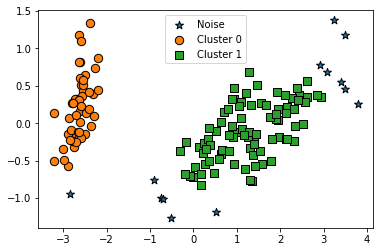

In [17]:
from sklearn.decomposition import PCA
# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)
# visualize_cluster_2d( ) 함수는 ftr1, ftr2 컬럼을 좌표에 표현하므로 PCA 변환값을 해당 컬럼으로 생성
irisDF['ftr1'] = pca_transformed[:,0]
irisDF['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: count, dtype: int64


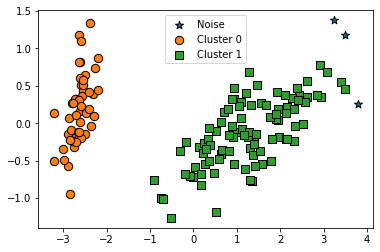

In [18]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: count, dtype: int64


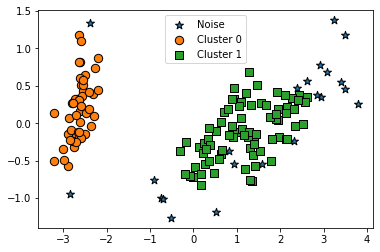

In [19]:
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

### DBSCAN 적용하기 – make_circles() 데이터 세트

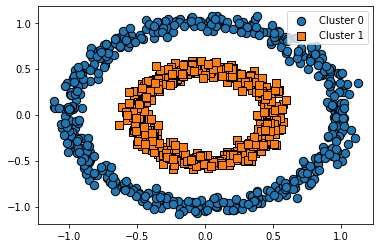

In [20]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, 
                    shuffle=True, 
                    noise=0.05, # 노이즈 데이터 세트의 비율
                    random_state=0, 
                    factor=0.5 # 내부 원과 외부 원의 scale 비율
                    )
# make_circles는 오직 2개의 feature만을 생성하므로 별도의 feature 개수를 지정할 필요 없음                    
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

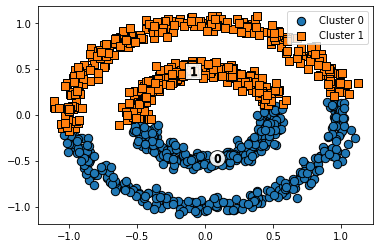

In [21]:
# KMeans로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

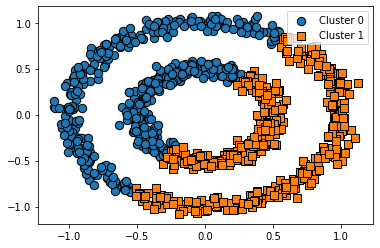

In [22]:
# GMM으로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

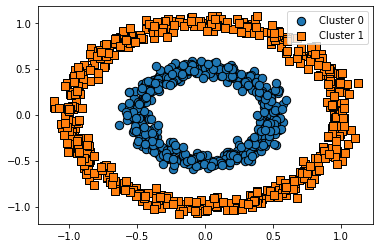

In [23]:
# DBSCAN으로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels

visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)